# Hypothesis Testing

In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

## Unfair coin

### simulation

In [3]:
ONE_CHANCE = 0.55
def flip_coin(sample_size:int)->list[int]:
    return np.random.choice([1, 0], sample_size, p=[ONE_CHANCE, 1-ONE_CHANCE])
flip_coin(10)

array([0, 1, 0, 0, 1, 1, 0, 0, 0, 0])

### Run testing

In [62]:
H0_VALUE = 0.5
def calculate_p_value(sample:list[bool]):
    n = len(sample)
    x_bar = np.mean(sample)
    s = np.std(sample)
    se = s / (n ** 0.5)
    z = abs(H0_VALUE - x_bar) / se
    p_value = 2 * st.norm.cdf(-z)
    confidence_interval = (x_bar - 1.96 * se, x_bar + 1.96 * se)
    return p_value, z, confidence_interval

In [60]:
def run_test(sample_size:int):
    sample = flip_coin(sample_size)
    p_value, z_score, confidence_interval = calculate_p_value(sample)
    return p_value, z_score, confidence_interval, p_value > 0.05, confidence_interval[0] < H0_VALUE < confidence_interval[1]

In [135]:
for i in [30,100,1000]:
    p_value, z_score, confidence_interval, result_z_test, result_confidence_interval = run_test(i)
    print(f"for size {i}\t, P_value is {p_value * 100:.2f}%\t, z_score is {z_score:.2f}\t, and H0 is {'reject' if not result_z_test else 'not reject'}")
    print(f"for size {i}\t, confidence interval is ({confidence_interval[0]:.3f},{confidence_interval[1]:.3f})%\t\t, and H0 is {'reject' if not result_confidence_interval else 'not reject'}")

for size 30	, P_value is 100.00%	, z_score is 0.00	, and H0 is not reject
for size 30	, confidence interval is (0.321,0.679)%		, and H0 is not reject
for size 100	, P_value is 100.00%	, z_score is 0.00	, and H0 is not reject
for size 100	, confidence interval is (0.402,0.598)%		, and H0 is not reject
for size 1000	, P_value is 0.35%	, z_score is 2.92	, and H0 is reject
for size 1000	, confidence interval is (0.515,0.577)%		, and H0 is reject
for size 1000000	, P_value is 0.00%	, z_score is 101.88	, and H0 is reject
for size 1000000	, confidence interval is (0.550,0.552)%		, and H0 is reject


In [51]:
ans = list()
for i in range(100, 10000, 10):
    p_value, z_score, confidence_interval, result_z_test, result_confidence_interval = run_test(i)
    ans += [p_value*100]

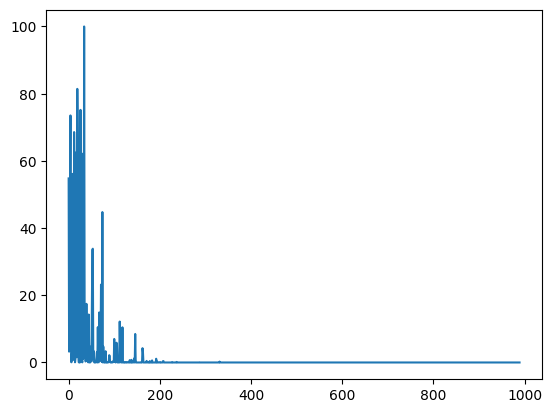

In [52]:
plt.plot(ans)